# Create Regions of Interests

## Set Up

In [25]:
import os
import numpy as np

from nilearn.maskers import NiftiMasker
from nltools.data import Brain_Data
from nilearn.plotting import plot_glass_brain, plot_stat_map, plot_roi
from nltools.mask import expand_mask
from nilearn.image import resample_to_img


from nilearn.image import math_img, smooth_img
from nilearn import datasets

import SUITPy as suit
import SUITPy.flatmap as flatmap

import matplotlib.pyplot as plt

from nitools import make_func_gifti, make_label_gifti


### Set Directories

In [2]:
bids_dir = '/Users/hpopal/Google Drive/My Drive/dscn_lab/projects/trw/'
os.chdir(bids_dir)

data_dir = os.path.join(bids_dir, 'derivatives', 'rois')

### Set mask for transformations
**Note:** Study data is in MNI space with 2mm voxels, so this is not used in this current script.

In [3]:
subj_mask = bids_dir+'derivatives/fmriprep/sub-REDTRW001/func/sub-REDTRW001_task-scr_run-2_space-MNIPediatricAsym_cohort-5_res-2_desc-brain_mask.nii.gz' 


## Create Cerebellum ROIs
Cerebellum ROIs will be from the Multi-Domain Task Battery (MDTB) from [King et al., 2019](https://www.nature.com/articles/s41593-019-0436-x). There are 10 ROIs, derived from a task-based parcellation of fMRI data.

/Users/hpopal/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/Users/hpopal/anaconda3/lib/python3.11/site-packages/joblib/memory.py:312: UserWarning: Casting data from int8 to float32
  return self.func(*args, **kwargs)


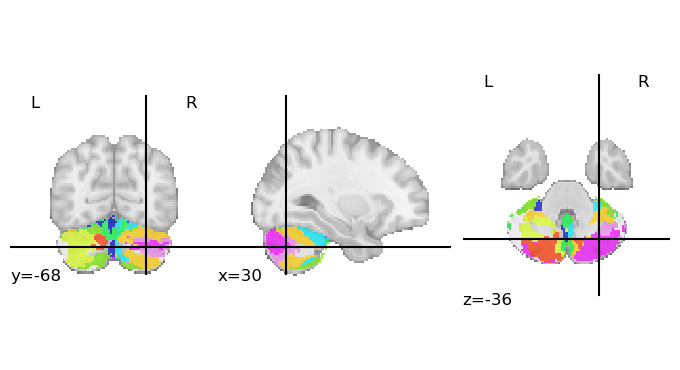

In [16]:
atlas_path = data_dir+'/cerebellar_atlases-master/King_2019/atl-MDTB10_space-MNI_dseg.nii' 

mdtb_atlas = Brain_Data(atlas_path)

plot_roi(mdtb_atlas.to_nifti())

### Export individual ROIs

In [17]:
mdtb_rois = expand_mask(mdtb_atlas)

for n in range(len(mdtb_rois)):
    mdtb_rois[n].to_nifti().to_filename(data_dir+'/mdtb_region'+str(n+1).zfill(2)+'.nii.gz')

/Users/hpopal/anaconda3/lib/python3.11/site-packages/nilearn/masking.py:980: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


### Visualize an individual ROI

/Users/hpopal/anaconda3/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/Users/hpopal/anaconda3/lib/python3.11/site-packages/joblib/memory.py:312: UserWarning: Casting data from int32 to float32
  return self.func(*args, **kwargs)
/Users/hpopal/anaconda3/lib/python3.11/site-packages/nilearn/image/resampling.py:293: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(


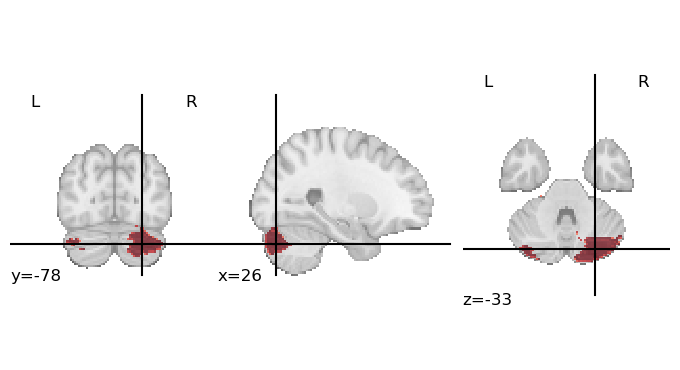

In [18]:
mdtb_roi = Brain_Data(data_dir+'/mdtb_region08.nii.gz', mask=subj_mask)

plot_roi(mdtb_roi.to_nifti(), cmap='Reds')

## Retrieve Cerebrum Atlas
The cerebrum atlas will be the 100 region parcellation from [Schaefer et al., 2018, via Nilearn](https://nilearn.github.io/dev/modules/description/schaefer_2018.html). 

In [19]:
# Pull the Yeo atlas, for convient labelling of each region
atlas_yeo_2011 = datasets.fetch_atlas_yeo_2011(data_dir=data_dir)
atlas_yeo = atlas_yeo_2011.thick_7


# Create individual regions from the atlas
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=100, resolution_mm=2, data_dir=data_dir)
atlas_regions = atlas.maps
atlas.labels = np.insert(atlas.labels, 0, 'Background')

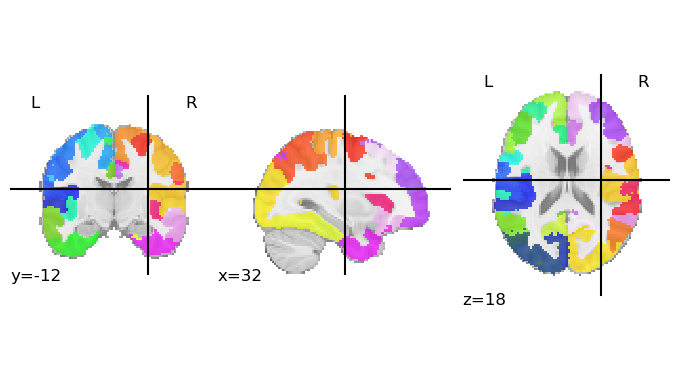

In [20]:
sch100_atlas = Brain_Data(atlas_regions)
plot_roi(sch100_atlas.to_nifti())

## Combine Atlases
We will combine the cerebellum and cerebrum atlases into one atlas.

In [22]:
# Add 100 to all values of cerebellum atlas, so they are unique from the cerebrum ROIs
mdtb_atlas.data += 100

# Zero all values below 101, that aren't an actual region
mdtb_atlas.data[mdtb_atlas.data < 101] = 0

# Round and turn into integer
#mdtb_atlas.data = np.rint(mdtb_atlas.data).astype(int)

np.unique(mdtb_atlas.data)

array([  0, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110])

/Users/hpopal/anaconda3/lib/python3.11/site-packages/nilearn/masking.py:980: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


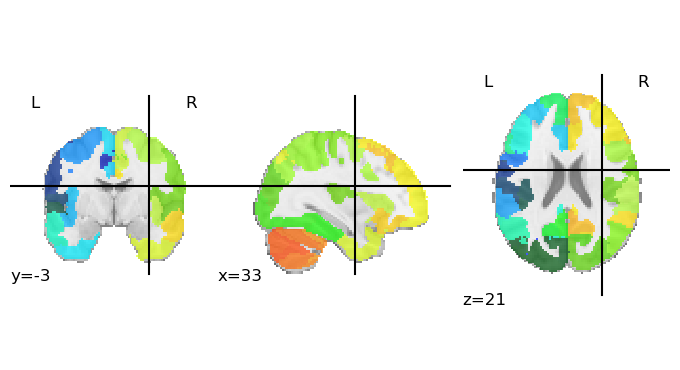

In [23]:
# Combine atlases
sch100_mdtb = math_img('img1 + img2', img1=sch100_atlas.to_nifti(), img2=mdtb_atlas.to_nifti())

plot_roi(sch100_mdtb)

In [24]:
# Export
sch100_mdtb.to_filename(data_dir+'/sch100_mdtb.nii.gz')